# Credit Card Fraud Detection Model Training

Этот ноутбук обучает модель машинного обучения для детекции мошенничества с кредитными картами.

## Шаги:
1. Загрузка и исследование данных
2. Предобработка данных
3. Разделение на train/test
4. Обучение модели LightGBM
5. Оценка качества модели
6. Сохранение модели и скейлера

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import joblib
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Загрузка данных

Убедитесь, что файл `creditcard.csv` находится в папке `data/`.
Если файла нет, скачайте его с Kaggle:
```bash
kaggle datasets download -d mlg-ulb/creditcardfraud
```

In [2]:
# Загрузка данных
try:
    df = pd.read_csv('../data/creditcard.csv')
    print(f"Данные загружены успешно. Размер: {df.shape}")
except FileNotFoundError:
    print("Файл creditcard.csv не найден в папке data/")
    print("Скачайте датасет с Kaggle: kaggle datasets download -d mlg-ulb/creditcardfraud")
    raise

Данные загружены успешно. Размер: (284807, 31)


In [3]:
# Исследование данных
print("Первые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nСтатистика:")
print(df.describe())

Первые 5 строк:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26     

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.175161e-15  3.384974e-16 -1.379537e-15  2.094852e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.021879e-15  1.494498e-15 -5.620335e-16  1.149614e-16 -2.414189e-15   
std    1.380247e+00  1.332271e+00  1.23709

Распределение классов:
Class
0    284315
1       492
Name: count, dtype: int64

Доля мошеннических транзакций: 0.0017


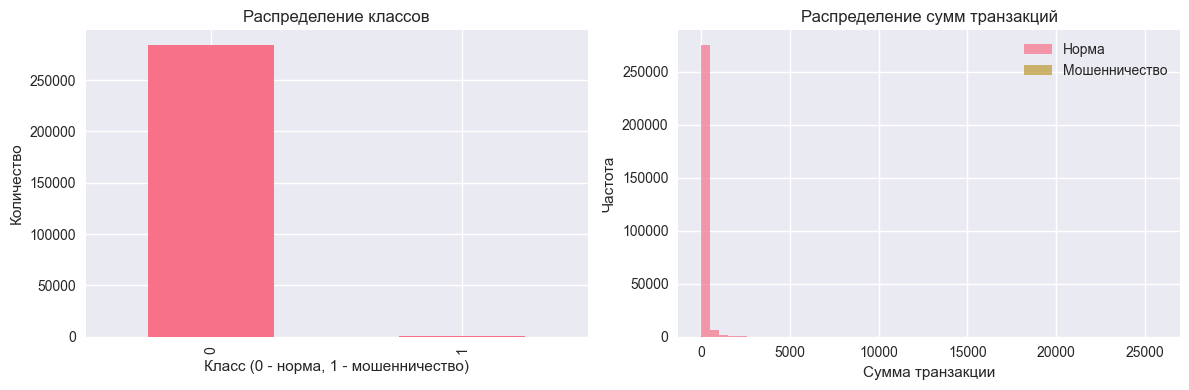

In [4]:
# Анализ целевой переменной
print("Распределение классов:")
print(df['Class'].value_counts())
print(f"\nДоля мошеннических транзакций: {df['Class'].mean():.4f}")

# Визуализация
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df['Class'].value_counts().plot(kind='bar')
plt.title('Распределение классов')
plt.xlabel('Класс (0 - норма, 1 - мошенничество)')
plt.ylabel('Количество')

plt.subplot(1, 2, 2)
plt.hist(df[df['Class'] == 0]['Amount'], bins=50, alpha=0.7, label='Норма')
plt.hist(df[df['Class'] == 1]['Amount'], bins=50, alpha=0.7, label='Мошенничество')
plt.xlabel('Сумма транзакции')
plt.ylabel('Частота')
plt.legend()
plt.title('Распределение сумм транзакций')

plt.tight_layout()
plt.show()

## 2. Предобработка данных

In [5]:
# Проверка на пропущенные значения
print("Пропущенные значения:")
print(df.isnull().sum().sum())

# Подготовка признаков и целевой переменной
X = df.drop(['Class'], axis=1)
y = df['Class']

print(f"\nРазмер признаков: {X.shape}")
print(f"Размер целевой переменной: {y.shape}")

Пропущенные значения:
0

Размер признаков: (284807, 30)
Размер целевой переменной: (284807,)


In [6]:
# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Доля мошенничества в train: {y_train.mean():.4f}")
print(f"Доля мошенничества в test: {y_test.mean():.4f}")

Размер обучающей выборки: (227845, 30)
Размер тестовой выборки: (56962, 30)
Доля мошенничества в train: 0.0017
Доля мошенничества в test: 0.0017


In [7]:
# Нормализация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Нормализация завершена")
print(f"Среднее значение после нормализации: {X_train_scaled.mean():.6f}")
print(f"Стандартное отклонение после нормализации: {X_train_scaled.std():.6f}")

Нормализация завершена
Среднее значение после нормализации: -0.000000
Стандартное отклонение после нормализации: 1.000000


## 3. Обучение моделей

In [8]:
# Обучение LightGBM
print("Обучение LightGBM...")

lgb_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.05,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    verbose=0,
    random_state=42,
    class_weight='balanced'
)

lgb_model.fit(X_train_scaled, y_train)
print("LightGBM обучена")

Обучение LightGBM...


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LightGBM обучена


In [9]:
# Обучение Logistic Regression для сравнения
print("Обучение Logistic Regression...")

lr_model = LogisticRegression(
    random_state=42,
    class_weight='balanced',
    max_iter=1000
)

lr_model.fit(X_train_scaled, y_train)
print("Logistic Regression обучена")

Обучение Logistic Regression...


Logistic Regression обучена


## 4. Оценка моделей

In [10]:
# Предсказания
lgb_pred = lgb_model.predict(X_test_scaled)
lgb_pred_proba = lgb_model.predict_proba(X_test_scaled)[:, 1]

lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Оценка качества
print("=== LightGBM ===")
print(f"ROC-AUC: {roc_auc_score(y_test, lgb_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lgb_pred))

print("\n=== Logistic Regression ===")
print(f"ROC-AUC: {roc_auc_score(y_test, lr_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred))

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
=== LightGBM ===
ROC-AUC: 0.9714

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.51      0.89      0.65        98

    accuracy                           1.00     56962
   macro avg       0.76    

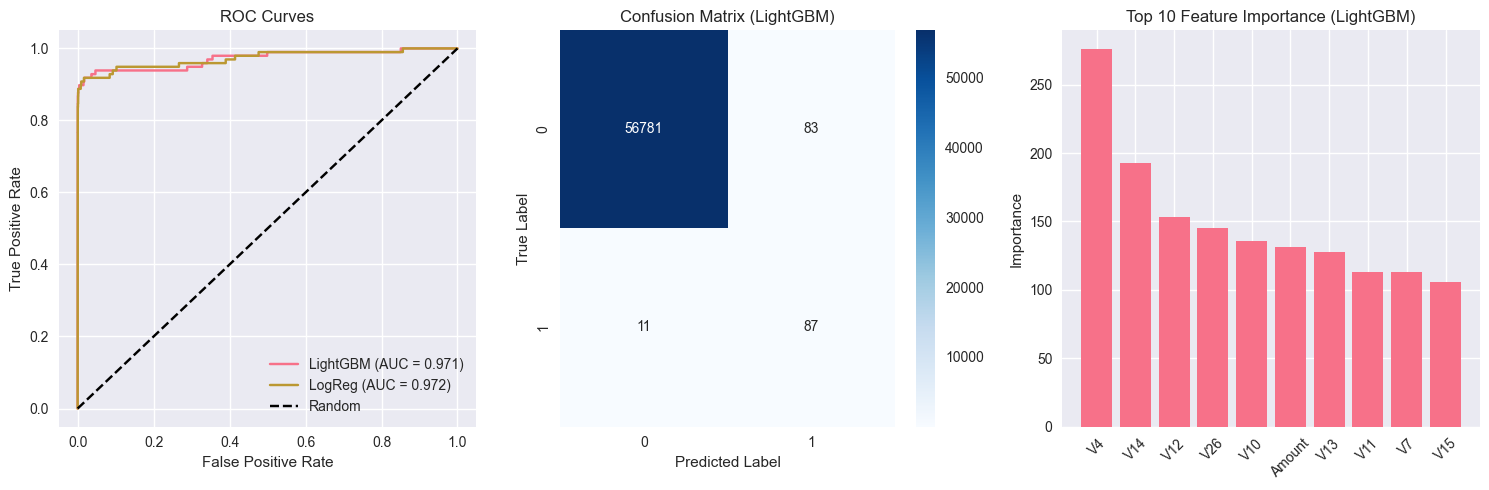

In [11]:
# Визуализация результатов
plt.figure(figsize=(15, 5))

# ROC кривые
plt.subplot(1, 3, 1)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, lgb_pred_proba)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_pred_proba)

plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {roc_auc_score(y_test, lgb_pred_proba):.3f})')
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC = {roc_auc_score(y_test, lr_pred_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()

# Confusion Matrix для LightGBM
plt.subplot(1, 3, 2)
cm_lgb = confusion_matrix(y_test, lgb_pred)
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (LightGBM)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Feature importance для LightGBM
plt.subplot(1, 3, 3)
feature_importance = lgb_model.feature_importances_
feature_names = X.columns
indices = np.argsort(feature_importance)[::-1][:10]

plt.bar(range(10), feature_importance[indices])
plt.xticks(range(10), [feature_names[i] for i in indices], rotation=45)
plt.title('Top 10 Feature Importance (LightGBM)')
plt.ylabel('Importance')

plt.tight_layout()
plt.show()

## 5. Выбор лучшей модели и сохранение

In [12]:
# Сравнение моделей по ROC-AUC
lgb_auc = roc_auc_score(y_test, lgb_pred_proba)
lr_auc = roc_auc_score(y_test, lr_pred_proba)

print(f"LightGBM ROC-AUC: {lgb_auc:.4f}")
print(f"Logistic Regression ROC-AUC: {lr_auc:.4f}")

# Выбираем лучшую модель
if lgb_auc >= lr_auc:
    best_model = lgb_model
    best_model_name = "LightGBM"
    best_auc = lgb_auc
else:
    best_model = lr_model
    best_model_name = "Logistic Regression"
    best_auc = lr_auc

print(f"\nЛучшая модель: {best_model_name} с ROC-AUC = {best_auc:.4f}")

LightGBM ROC-AUC: 0.9714
Logistic Regression ROC-AUC: 0.9721

Лучшая модель: Logistic Regression с ROC-AUC = 0.9721


In [13]:
# Сохранение модели и скейлера
import os

model_dir = '../model'
os.makedirs(model_dir, exist_ok=True)

# Сохраняем модель
joblib.dump(best_model, os.path.join(model_dir, 'model.pkl'))
print(f"Модель {best_model_name} сохранена в {model_dir}/model.pkl")

# Сохраняем скейлер
joblib.dump(scaler, os.path.join(model_dir, 'scaler.pkl'))
print(f"Скейлер сохранен в {model_dir}/scaler.pkl")

# Сохраняем метрики
metrics = {
    'model_name': best_model_name,
    'roc_auc': best_auc,
    'feature_names': list(X.columns)
}

joblib.dump(metrics, os.path.join(model_dir, 'metrics.pkl'))
print(f"Метрики сохранены в {model_dir}/metrics.pkl")

Модель Logistic Regression сохранена в ../model/model.pkl
Скейлер сохранен в ../model/scaler.pkl
Метрики сохранены в ../model/metrics.pkl


## 6. Тестирование сохраненной модели

In [14]:
# Загрузка сохраненной модели для проверки
loaded_model = joblib.load('../model/model.pkl')
loaded_scaler = joblib.load('../model/scaler.pkl')
loaded_metrics = joblib.load('../model/metrics.pkl')

print("Модель успешно загружена")
print(f"Модель: {loaded_metrics['model_name']}")
print(f"ROC-AUC: {loaded_metrics['roc_auc']:.4f}")

# Тестируем на одной транзакции
sample_transaction = X_test.iloc[0:1]
sample_scaled = loaded_scaler.transform(sample_transaction)
prediction = loaded_model.predict_proba(sample_scaled)[0, 1]

print(f"\nТест на примере транзакции:")
print(f"Вероятность мошенничества: {prediction:.4f}")
print(f"Классификация: {'Мошенничество' if prediction > 0.5 else 'Норма'}")
print(f"Реальный класс: {'Мошенничество' if y_test.iloc[0] == 1 else 'Норма'}")

Модель успешно загружена
Модель: Logistic Regression
ROC-AUC: 0.9721

Тест на примере транзакции:
Вероятность мошенничества: 0.0057
Классификация: Норма
Реальный класс: Норма


## Заключение

Модель обучена и сохранена. Теперь можно использовать её в API для предсказания мошенничества в реальном времени.

Файлы сохранены:
- `model/model.pkl` - обученная модель
- `model/scaler.pkl` - скейлер для нормализации
- `model/metrics.pkl` - метрики модели